# Cox-PH and DeepSurv

In this notebook we will train the [Cox-PH method](http://jmlr.org/papers/volume20/18-424/18-424.pdf), also known as [DeepSurv](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-018-0482-1).
We will use the METABRIC data sets as an example

A more detailed introduction to the `pycox` package can be found in [this notebook](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/01_introduction.ipynb) about the `LogisticHazard` method.

The main benefit Cox-CC (and the other Cox methods) has over Logistic-Hazard is that it is a continuous-time method, meaning we do not need to discretize the time scale.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchtuples as tt
import pandas as pd
import os
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import MinMaxScaler
from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from datetime import datetime
from sklearn.metrics import mean_squared_error

In [2]:
## Uncomment to install `sklearn-pandas`
# ! pip install sklearn-pandas

In [3]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## Dataset

We load the METABRIC data set and split in train, test and validation.

## Feature transforms
We have 9 covariates, in addition to the durations and event indicators.

We will standardize the 5 numerical covariates, and leave the binary variables as is. As variables needs to be of type `'float32'`, as this is required by pytorch.

In [4]:
# Load dataset
data = pd.read_csv("data/Recurrence free survival in breast cancer patients.csv")

# Define column types
CONTINUOUS_VARIABLES = ["age", "size", "nodes", "prog", "oest"]
CATEGORICAL_VARIABLES = ["treat", "men", "grade"]

# Scale continuous variables
# scaler = MinMaxScaler()
# data[CONTINUOUS_VARIABLES] = scaler.fit_transform(data[CONTINUOUS_VARIABLES])

# One-hot encode categorical variables
data = pd.get_dummies(data, columns=CATEGORICAL_VARIABLES, drop_first=True)

# Sort by status to isolate uncensored samples
data = data.sort_values("status").reset_index(drop=True)

# Select last 100 uncensored rows for test set
uncensored = data[data["status"] == 1]
df_test = uncensored.iloc[-75:]
df_trainval = data.drop(df_test.index)

# Sample 20% of training set for validation
df_val = df_trainval.sample(frac=0.2, random_state=42)
df_train = df_trainval.drop(df_val.index)

# Define predictors after one-hot encoding
PREDS = [
    "age", "size", "nodes", "prog", "oest",
    "treat_1", "men_2", "grade_2", "grade_3"
]

# Features (scaled, non scaled is commented out)
# standardize = DataFrameMapper([
#     (["age"], StandardScaler()),
#     (["size"], StandardScaler()),
#     (["nodes"], StandardScaler()),
#     (["prog"], StandardScaler()),
#     (["oest"], StandardScaler()),
#     (["treat_1"], None),
#     (["men_2"], None),
#     (["grade_2"], None),
#     (["grade_3"], None)
# ], df_out=True)

# x_train = standardize.fit_transform(df_train).astype("float32").values
# x_val = standardize.transform(df_val).astype("float32").values
# x_test = standardize.transform(df_test).astype("float32").values

x_train = df_train[PREDS].astype("float32").values
x_val = df_val[PREDS].astype("float32").values
x_test = df_test[PREDS].astype("float32").values

# Targets
get_target = lambda df: (df["time"].astype(float).values, df["status"].astype(bool).values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

In [5]:
df_test[PREDS]

,age,size,nodes,prog,oest,treat_1,men_2,grade_2,grade_3
611,48,22,4,14,0,False,True,True,False
612,52,35,1,8,5,False,True,False,True
613,60,21,1,58,701,False,True,True,False
614,48,35,10,2,222,False,False,False,True
615,59,27,20,9,2,False,True,False,True
...,...,...,...,...,...,...,...,...,...
681,68,14,6,40,68,True,True,True,False
682,64,24,2,41,80,False,True,True,False
683,58,56,11,51,50,True,True,False,False
684,51,34,3,13,12,True,False,True,False


We need no label transforms

## Neural net

We create a simple MLP with two hidden layers, ReLU activations, batch norm and dropout. 
Here, we just use the `torchtuples.practical.MLPVanilla` net to do this.

Note that we set `out_features` to 1, and that we have not `output_bias`.

In [6]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

## Training the model

To train the model we need to define an optimizer. You can choose any `torch.optim` optimizer, but here we instead use one from `tt.optim` as it has some added functionality.
We use the `Adam` optimizer, but instead of choosing a learning rate, we will use the scheme proposed by [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf) to find a suitable learning rate with `model.lr_finder`. See [this post](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for an explanation.

In [7]:
model = CoxPH(net, tt.optim.Adam)

/opt/miniconda3/lib/python3.9/site-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


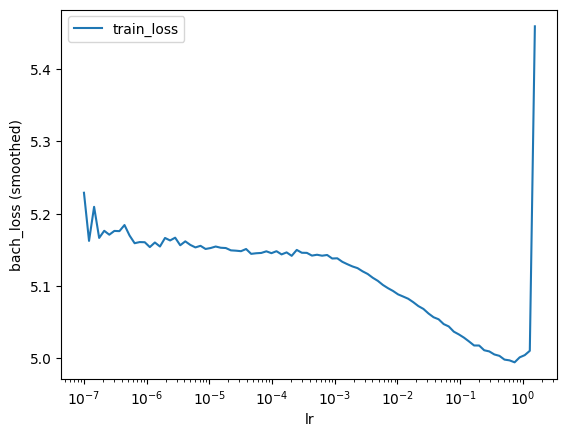

In [8]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [9]:
lrfinder.get_best_lr()

0.07390722033525823

Often, this learning rate is a little high, so we instead set it manually to 0.01

In [10]:
model.optimizer.set_lr(0.01)

We include the `EarlyStopping` callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.

In [11]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [12]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 5.0791,	val_loss: 4.2458
1:	[0s / 0s],		train_loss: 4.9719,	val_loss: 4.1724
2:	[0s / 0s],		train_loss: 4.9446,	val_loss: 4.1439
3:	[0s / 0s],		train_loss: 4.9488,	val_loss: 4.1467
4:	[0s / 0s],		train_loss: 4.8951,	val_loss: 4.1563
5:	[0s / 0s],		train_loss: 4.8893,	val_loss: 4.1462
6:	[0s / 0s],		train_loss: 4.8505,	val_loss: 4.1514
7:	[0s / 0s],		train_loss: 4.8511,	val_loss: 4.1573
8:	[0s / 0s],		train_loss: 4.8406,	val_loss: 4.1571
9:	[0s / 0s],		train_loss: 4.8440,	val_loss: 4.1600
10:	[0s / 0s],		train_loss: 4.8338,	val_loss: 4.1613
11:	[0s / 0s],		train_loss: 4.8007,	val_loss: 4.1607
12:	[0s / 0s],		train_loss: 4.8070,	val_loss: 4.1443
CPU times: user 47.2 ms, sys: 23.4 ms, total: 70.6 ms
Wall time: 57.6 ms


/opt/miniconda3/lib/python3.9/site-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


In [13]:
model.compute_baseline_hazards(x_train, y_train)

duration
8.0       0.0
15.0      0.0
16.0      0.0
17.0      0.0
18.0      0.0
         ... 
2551.0    0.0
2556.0    0.0
2563.0    0.0
2612.0    0.0
2659.0    0.0
Name: baseline_hazards, Length: 434, dtype: float64

In [14]:
#Pickle


# Create 'pickle' directory if it doesn't exist
os.makedirs('pickle', exist_ok=True)

# Generate a unique filename using timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"deepsurv_model_{timestamp}.pkl"
filepath = os.path.join('pickle', filename)

# Save model and components
# Scaler commented out
with open(filepath, 'wb') as f:
    pickle.dump({
        'model_state_dict': model.net.state_dict(),
        'model_structure': model.net,
        'baseline_hazards': model.baseline_hazards_.copy(),
        'baseline_cumulative_hazards': model.baseline_cumulative_hazards_.copy()
#       'scaler': standardize
    }, f)

print(f"Model saved to {filepath}")

Model saved to pickle/deepsurv_model_20250421_142820.pkl


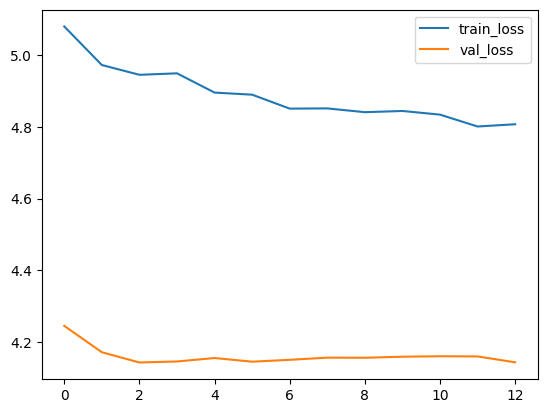

In [15]:
_ = log.plot()

We can get the partial log-likelihood

In [16]:
model.partial_log_likelihood(*val).mean()

-4.1439323

## Prediction

For evaluation we first need to obtain survival estimates for the test set.
This can be done with `model.predict_surv` which returns an array of survival estimates, or with `model.predict_surv_df` which returns the survival estimates as a dataframe.

However, as `CoxPH` is semi-parametric, we first need to get the non-parametric baseline hazard estimates with `compute_baseline_hazards`. 

Note that for large datasets the `sample` argument can be used to estimate the baseline hazard on a subset.

In [17]:
_ = model.compute_baseline_hazards()

In [18]:
surv = model.predict_surv_df(x_test)

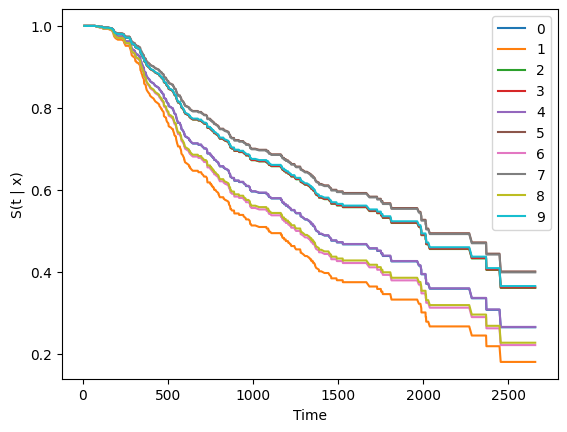

In [19]:
surv.iloc[:, :10].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

## Evaluation

We can use the `EvalSurv` class for evaluation the concordance, brier score and binomial log-likelihood. Setting `censor_surv='km'` means that we estimate the censoring distribution by Kaplan-Meier on the test set.

In [20]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [21]:
print(f"Concordance: {ev.concordance_td():.3f}")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Concordance: 0.642


C-score without scaling: 0.642
C-score with scaling: 0.583

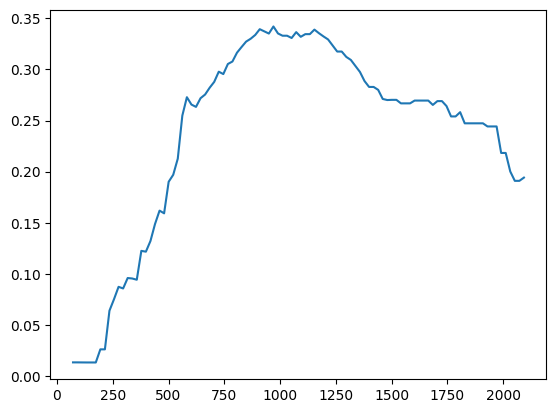

In [22]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [23]:
ev.integrated_brier_score(time_grid)

0.23973280618525528

In [24]:
ev.integrated_nbll(time_grid)

0.6628618038028656

In [25]:

# Step 1: Predict survival functions using your trained DeepSurv model
surv_df = model.predict_surv_df(x_test)

# Step 2: Get time grid
time_grid = surv_df.index.values

# Step 3: Define function to get median survival time
def get_median_time(surv_probs, times):
    for s, t in zip(surv_probs, times):
        if s <= 0.5:
            return t
    return times[-1]

# Step 4: Compute predicted median survival times
predicted_medians = []
for i in range(surv_df.shape[1]):
    surv_probs = surv_df.iloc[:, i].values
    predicted_medians.append(get_median_time(surv_probs, time_grid))
predicted_medians = np.array(predicted_medians)

# Step 5: Use only uncensored test samples
mask_uncensored = df_test["status"] == 1
observed_times = df_test.loc[mask_uncensored, "time"].values
predicted_times = predicted_medians[mask_uncensored.values]

# Step 6: Compute RMSE
rmse = np.sqrt(mean_squared_error(observed_times, predicted_times))
print(f"DeepSurv Test RMSE: {rmse:.4f}")

DeepSurv Test RMSE: 1158.2391
